# Colab Setup  
> Make sure you configure notebook with GPU: Click Edit->notebook settings->hardware accelerator->GPU

> Uncomment the following cell after opening in Google colab. (Do not uncomment it in local setup.)  

<a target="_blank" href="https://colab.research.google.com/github/SEED-VT/FedDebug/blob/main/fault-localization/Reproduce_Figure4-Figure7.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



In [1]:
# !pip install pytorch-lightning
# !pip install diskcache
# !pip install dotmap
# !pip install torch torchvision torchaudio
# !pip install matplotlib
# !git clone https://github.com/SEED-VT/FedDebug.git
# # appending the path
# import sys
# sys.path.append("FedDebug/fault-localization/")

# Running Code

In [2]:
import logging
import matplotlib.pyplot as plt
import time
from dotmap import DotMap
from pytorch_lightning import seed_everything
from torch.nn.init import kaiming_uniform_ 
from utils.faulty_client_localization.FaultyClientLocalization import FaultyClientLocalization
from utils.faulty_client_localization.InferenceGuidedInputs import InferenceGuidedInputs
from utils.FLSimulation import trainFLMain
from utils.fl_datasets import initializeTrainAndValidationDataset
from utils.util import aggToUpdateGlobalModel
from utils.util import testAccModel



logging.basicConfig(filename='example.log', level=logging.ERROR)
logger = logging.getLogger("pytorch_lightning")
seed_everything(786)



def evaluateFaultLocalization(predicted_faulty_clients_on_each_input, true_faulty_clients):
    true_faulty_clients = set(true_faulty_clients)
    detection_acc = 0
    for pred_faulty_clients in predicted_faulty_clients_on_each_input:
        print(f"+++ Faulty Clients {pred_faulty_clients}")
        correct_localize_faults = len(
            true_faulty_clients.intersection(pred_faulty_clients))
        acc = (correct_localize_faults/len(true_faulty_clients))*100
        detection_acc += acc
    fault_localization_acc = detection_acc / \
        len(predicted_faulty_clients_on_each_input)
    return fault_localization_acc


def runFaultyClientLocalization(client2models, exp2info, num_bugs, random_generator=kaiming_uniform_, apply_transform=True, k_gen_inputs=10, na_threshold=0.003, use_gpu=True):
    print(">  Running FaultyClientLocalization ..")
    input_shape = list(exp2info['data_config']['single_input_shape'])
    generate_inputs = InferenceGuidedInputs(client2models, input_shape, randomGenerator=random_generator, apply_transform=apply_transform,
                                            dname=exp2info['data_config']['name'], min_nclients_same_pred=5, k_gen_inputs=k_gen_inputs)
    selected_inputs, input_gen_time = generate_inputs.getInputs()

    start = time.time()
    faultyclientlocalization = FaultyClientLocalization(
        client2models, selected_inputs, use_gpu=use_gpu)

    potential_benign_clients_for_each_input = faultyclientlocalization.runFaultLocalization(
        na_threshold, num_bugs=num_bugs)
    fault_localization_time = time.time()-start
    return potential_benign_clients_for_each_input, input_gen_time, fault_localization_time





# ====== Simulation ===== 

args = DotMap()
args.lr = 0.001
args.weight_decay = 0.0001
args.batch_size = 512

nosie2results = []
different_noise_levels = [0.1, 0.3, 0.5, 0.7, 0.9, 1]
args.model = "resnet18" # [resnet18, resnet34, resnet50, densenet121, vgg16]
args.epochs = 5  # range 10-25
args.dataset = "cifar10" # ['cifar10', 'femnist']
args.clients = 10 # keep under 30 clients and use Resnet18, Resnet34, or Densenet to evaluate on Colab 
args.faulty_clients_ids = "0" # can be multiple clients separated by comma e.g. "0,1,2"  but keep under args.clients clients and at max less than 7 
args.sampling = "iid" # [iid, "niid"] 

_,test_data, _ =  initializeTrainAndValidationDataset(args.dataset, ".storage/datasets/")

for noise_rate in different_noise_levels:
    args.noise_rate = noise_rate  # noise rate 0 to 1 
    # FL training
    c2ms, exp2info = trainFLMain(args)
    client2models = {k: v.model.eval() for k, v in c2ms.items()}

    gm =  aggToUpdateGlobalModel(clients_models=client2models)
    test_acc = testAccModel(gm, test_data)

    # Fault localazation
    potential_faulty_clients, _, _ = runFaultyClientLocalization(
        client2models=client2models, exp2info=exp2info, num_bugs=len(exp2info['faulty_clients_ids']))
    fault_acc = evaluateFaultLocalization(
        potential_faulty_clients, exp2info['faulty_clients_ids'])
    print(f"Fault Localization Acc: {fault_acc}")

    print(f"Gloabl Model Test Acc: {test_acc}, Noise Rate: {noise_rate}, Fault Acc: {fault_acc}")
    nosie2results.append((noise_rate, test_acc, fault_acc))



/home/gulzar/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 786
Global seed set to 786


Files already downloaded and verified
Files already downloaded and verified


  ***Simulating FL setup iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001 ***
Files already downloaded and verified
Files already downloaded and verified
Spliting Datasets 50000 into parts:[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
input shape, torch.Size([1, 3, 32, 32])
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/faulty_client_0_noise_rate_0.1_classes.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Train mod batch = 392, and drop_last = False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  7.01it/s, loss=0.938, train_acc=0.635, train_loss=0.946, val_acc=0.564, val_loss=1.760]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.99it/s, loss=0.938, train_acc=0.635, train_loss=0.946, val_acc=0.564, val_loss=1.760]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_1.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  7.16it/s, loss=0.772, train_acc=0.723, train_loss=0.762, val_acc=0.645, val_loss=1.290]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  7.14it/s, loss=0.772, train_acc=0.723, train_loss=0.762, val_acc=0.645, val_loss=1.290]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_2.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.92it/s, loss=0.784, train_acc=0.737, train_loss=0.710, val_acc=0.632, val_loss=1.270]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.90it/s, loss=0.784, train_acc=0.737, train_loss=0.710, val_acc=0.632, val_loss=1.270]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_3.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  7.08it/s, loss=0.736, train_acc=0.740, train_loss=0.756, val_acc=0.642, val_loss=1.390]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  7.06it/s, loss=0.736, train_acc=0.740, train_loss=0.756, val_acc=0.642, val_loss=1.390]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_4.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s, loss=0.731, train_acc=0.756, train_loss=0.667, val_acc=0.646, val_loss=1.190]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s, loss=0.731, train_acc=0.756, train_loss=0.667, val_acc=0.646, val_loss=1.190]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_5.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.85it/s, loss=0.767, train_acc=0.761, train_loss=0.704, val_acc=0.648, val_loss=1.240]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.82it/s, loss=0.767, train_acc=0.761, train_loss=0.704, val_acc=0.648, val_loss=1.240]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_6.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.74it/s, loss=0.739, train_acc=0.787, train_loss=0.608, val_acc=0.628, val_loss=1.480]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.72it/s, loss=0.739, train_acc=0.787, train_loss=0.608, val_acc=0.628, val_loss=1.480]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_7.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s, loss=0.725, train_acc=0.743, train_loss=0.658, val_acc=0.654, val_loss=1.180]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.13it/s, loss=0.725, train_acc=0.743, train_loss=0.658, val_acc=0.654, val_loss=1.180]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_8.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.96it/s, loss=0.73, train_acc=0.781, train_loss=0.721, val_acc=0.619, val_loss=1.750] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.94it/s, loss=0.73, train_acc=0.781, train_loss=0.721, val_acc=0.619, val_loss=1.750]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_9.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.34it/s, loss=0.719, train_acc=0.795, train_loss=0.581, val_acc=0.652, val_loss=1.200]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.32it/s, loss=0.719, train_acc=0.795, train_loss=0.581, val_acc=0.652, val_loss=1.200]
Total clients: 10
++Training is done: iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001
>  Running FaultyClientLocalization ..
Same prediction threshold 5
>> Deubg: Simple Random inputs
+++ Faulty Clients {9}
+++ Faulty Clients {9}
+++ Faulty Clients {0}
+++ Faulty Clients {9}
+++ Faulty Clients {0}
+++ Faulty Clients {9}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {9}
+++ Faulty Clients {0}
Fault Localization Acc: 50.0
Gloabl Model Test Acc: 69.24, Noise Rate: 0.1, Fault Acc: 50.0


  ***Simulating FL setup iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001 ***
Files already downloaded and verified
Files already downloaded and verified
Spliting Datasets 50000 into parts:[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
input shape, torch.Size([1, 3, 32, 32])
Training : .storage/ch

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s, loss=1.22, train_acc=0.470, train_loss=1.190, val_acc=0.425, val_loss=2.850]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s, loss=1.22, train_acc=0.470, train_loss=1.190, val_acc=0.425, val_loss=2.850]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_1.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.43it/s, loss=0.763, train_acc=0.739, train_loss=0.701, val_acc=0.633, val_loss=1.330]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.42it/s, loss=0.763, train_acc=0.739, train_loss=0.701, val_acc=0.633, val_loss=1.330]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_2.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s, loss=0.765, train_acc=0.752, train_loss=0.712, val_acc=0.638, val_loss=1.180]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.19it/s, loss=0.765, train_acc=0.752, train_loss=0.712, val_acc=0.638, val_loss=1.180]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_3.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.03it/s, loss=0.743, train_acc=0.777, train_loss=0.729, val_acc=0.642, val_loss=1.190]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.02it/s, loss=0.743, train_acc=0.777, train_loss=0.729, val_acc=0.642, val_loss=1.190]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_4.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.14it/s, loss=0.771, train_acc=0.689, train_loss=0.842, val_acc=0.630, val_loss=1.430]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s, loss=0.771, train_acc=0.689, train_loss=0.842, val_acc=0.630, val_loss=1.430]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_5.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.82it/s, loss=0.753, train_acc=0.749, train_loss=0.750, val_acc=0.632, val_loss=1.460]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s, loss=0.753, train_acc=0.749, train_loss=0.750, val_acc=0.632, val_loss=1.460]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_6.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.03it/s, loss=0.763, train_acc=0.778, train_loss=0.643, val_acc=0.638, val_loss=1.180]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.02it/s, loss=0.763, train_acc=0.778, train_loss=0.643, val_acc=0.638, val_loss=1.180]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_7.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.24it/s, loss=0.738, train_acc=0.753, train_loss=0.695, val_acc=0.633, val_loss=1.410]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.22it/s, loss=0.738, train_acc=0.753, train_loss=0.695, val_acc=0.633, val_loss=1.410]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_8.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.82it/s, loss=0.755, train_acc=0.747, train_loss=0.780, val_acc=0.637, val_loss=1.290]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s, loss=0.755, train_acc=0.747, train_loss=0.780, val_acc=0.637, val_loss=1.290]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_9.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.67it/s, loss=0.717, train_acc=0.803, train_loss=0.564, val_acc=0.667, val_loss=1.220]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.65it/s, loss=0.717, train_acc=0.803, train_loss=0.564, val_acc=0.667, val_loss=1.220]
Total clients: 10
++Training is done: iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001
>  Running FaultyClientLocalization ..
Same prediction threshold 5
>> Deubg: Simple Random inputs
+++ Faulty Clients {1}
+++ Faulty Clients {1}
+++ Faulty Clients {1}
+++ Faulty Clients {1}
+++ Faulty Clients {1}
+++ Faulty Clients {1}
+++ Faulty Clients {1}
+++ Faulty Clients {1}
+++ Faulty Clients {1}
+++ Faulty Clients {1}
Fault Localization Acc: 0.0
Gloabl Model Test Acc: 69.32, Noise Rate: 0.3, Fault Acc: 0.0


  ***Simulating FL setup iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001 ***
Files already downloaded and verified
Files already downloaded and verified
Spliting Datasets 50000 into parts:[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
input shape, torch.Size([1, 3, 32, 32])
Training : .storage/chec

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.91it/s, loss=1.63, train_acc=0.328, train_loss=1.580, val_acc=0.273, val_loss=2.190]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.90it/s, loss=1.63, train_acc=0.328, train_loss=1.580, val_acc=0.273, val_loss=2.190]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_1.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.91it/s, loss=0.742, train_acc=0.799, train_loss=0.590, val_acc=0.649, val_loss=1.240]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.90it/s, loss=0.742, train_acc=0.799, train_loss=0.590, val_acc=0.649, val_loss=1.240]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_2.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.96it/s, loss=0.762, train_acc=0.726, train_loss=0.781, val_acc=0.620, val_loss=1.420]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.95it/s, loss=0.762, train_acc=0.726, train_loss=0.781, val_acc=0.620, val_loss=1.420]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_3.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.94it/s, loss=0.807, train_acc=0.757, train_loss=0.655, val_acc=0.609, val_loss=1.420]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.92it/s, loss=0.807, train_acc=0.757, train_loss=0.655, val_acc=0.609, val_loss=1.420]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_4.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.98it/s, loss=0.748, train_acc=0.777, train_loss=0.655, val_acc=0.625, val_loss=1.390]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.97it/s, loss=0.748, train_acc=0.777, train_loss=0.655, val_acc=0.625, val_loss=1.390]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_5.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.87it/s, loss=0.76, train_acc=0.732, train_loss=0.757, val_acc=0.638, val_loss=1.310] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.85it/s, loss=0.76, train_acc=0.732, train_loss=0.757, val_acc=0.638, val_loss=1.310]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_6.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.90it/s, loss=0.738, train_acc=0.756, train_loss=0.726, val_acc=0.661, val_loss=1.240]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.89it/s, loss=0.738, train_acc=0.756, train_loss=0.726, val_acc=0.661, val_loss=1.240]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_7.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.95it/s, loss=0.756, train_acc=0.753, train_loss=0.716, val_acc=0.638, val_loss=1.330]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.94it/s, loss=0.756, train_acc=0.753, train_loss=0.716, val_acc=0.638, val_loss=1.330]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_8.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.76it/s, loss=0.776, train_acc=0.774, train_loss=0.694, val_acc=0.601, val_loss=1.640]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.74it/s, loss=0.776, train_acc=0.774, train_loss=0.694, val_acc=0.601, val_loss=1.640]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_9.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.08it/s, loss=0.751, train_acc=0.773, train_loss=0.690, val_acc=0.640, val_loss=1.280]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.06it/s, loss=0.751, train_acc=0.773, train_loss=0.690, val_acc=0.640, val_loss=1.280]
Total clients: 10
++Training is done: iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001
>  Running FaultyClientLocalization ..
Same prediction threshold 5
>> Deubg: Simple Random inputs
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
Fault Localization Acc: 100.0
Gloabl Model Test Acc: 67.16, Noise Rate: 0.5, Fault Acc: 100.0


  ***Simulating FL setup iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001 ***
Files already downloaded and verified
Files already downloaded and verified
Spliting Datasets 50000 into parts:[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
input shape, torch.Size([1, 3, 32, 32])
Training : .storage/

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.80it/s, loss=1.92, train_acc=0.193, train_loss=1.900, val_acc=0.178, val_loss=2.410]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.78it/s, loss=1.92, train_acc=0.193, train_loss=1.900, val_acc=0.178, val_loss=2.410]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_1.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.68it/s, loss=0.745, train_acc=0.751, train_loss=0.783, val_acc=0.645, val_loss=1.110]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.67it/s, loss=0.745, train_acc=0.751, train_loss=0.783, val_acc=0.645, val_loss=1.110]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_2.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.24it/s, loss=0.761, train_acc=0.779, train_loss=0.715, val_acc=0.637, val_loss=1.270]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.23it/s, loss=0.761, train_acc=0.779, train_loss=0.715, val_acc=0.637, val_loss=1.270]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_3.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.55it/s, loss=0.75, train_acc=0.784, train_loss=0.710, val_acc=0.639, val_loss=1.210] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.54it/s, loss=0.75, train_acc=0.784, train_loss=0.710, val_acc=0.639, val_loss=1.210]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_4.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.62it/s, loss=0.74, train_acc=0.759, train_loss=0.692, val_acc=0.653, val_loss=1.230] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.60it/s, loss=0.74, train_acc=0.759, train_loss=0.692, val_acc=0.653, val_loss=1.230]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_5.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.97it/s, loss=0.735, train_acc=0.762, train_loss=0.593, val_acc=0.650, val_loss=1.200]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.96it/s, loss=0.735, train_acc=0.762, train_loss=0.593, val_acc=0.650, val_loss=1.200]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_6.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.79it/s, loss=0.791, train_acc=0.756, train_loss=0.715, val_acc=0.629, val_loss=1.210]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.77it/s, loss=0.791, train_acc=0.756, train_loss=0.715, val_acc=0.629, val_loss=1.210]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_7.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.70it/s, loss=0.733, train_acc=0.781, train_loss=0.727, val_acc=0.660, val_loss=1.110]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.69it/s, loss=0.733, train_acc=0.781, train_loss=0.727, val_acc=0.660, val_loss=1.110]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_8.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.57it/s, loss=0.764, train_acc=0.789, train_loss=0.593, val_acc=0.656, val_loss=1.210]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.56it/s, loss=0.764, train_acc=0.789, train_loss=0.593, val_acc=0.656, val_loss=1.210]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_9.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s, loss=0.723, train_acc=0.752, train_loss=0.743, val_acc=0.638, val_loss=1.250]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.80it/s, loss=0.723, train_acc=0.752, train_loss=0.743, val_acc=0.638, val_loss=1.250]
Total clients: 10
++Training is done: iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001
>  Running FaultyClientLocalization ..
Same prediction threshold 5
>> Deubg: Simple Random inputs
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
Fault Localization Acc: 100.0
Gloabl Model Test Acc: 69.6, Noise Rate: 0.7, Fault Acc: 100.0


  ***Simulating FL setup iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001 ***
Files already downloaded and verified
Files already downloaded and verified
Spliting Datasets 50000 into parts:[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
input shape, torch.Size([1, 3, 32, 32])
Training : .storage/c

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.87it/s, loss=2.18, train_acc=0.143, train_loss=2.170, val_acc=0.106, val_loss=2.420]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.85it/s, loss=2.18, train_acc=0.143, train_loss=2.170, val_acc=0.106, val_loss=2.420]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_1.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.82it/s, loss=0.728, train_acc=0.767, train_loss=0.668, val_acc=0.643, val_loss=1.310]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s, loss=0.728, train_acc=0.767, train_loss=0.668, val_acc=0.643, val_loss=1.310]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_2.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.95it/s, loss=0.734, train_acc=0.729, train_loss=0.775, val_acc=0.649, val_loss=1.360]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.94it/s, loss=0.734, train_acc=0.729, train_loss=0.775, val_acc=0.649, val_loss=1.360]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_3.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.80it/s, loss=0.736, train_acc=0.754, train_loss=0.707, val_acc=0.663, val_loss=1.160]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.78it/s, loss=0.736, train_acc=0.754, train_loss=0.707, val_acc=0.663, val_loss=1.160]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_4.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.41it/s, loss=0.769, train_acc=0.734, train_loss=0.767, val_acc=0.638, val_loss=1.350]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.39it/s, loss=0.769, train_acc=0.734, train_loss=0.767, val_acc=0.638, val_loss=1.350]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_5.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.98it/s, loss=0.749, train_acc=0.766, train_loss=0.691, val_acc=0.652, val_loss=1.120]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.97it/s, loss=0.749, train_acc=0.766, train_loss=0.691, val_acc=0.652, val_loss=1.120]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_6.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.95it/s, loss=0.77, train_acc=0.694, train_loss=0.820, val_acc=0.626, val_loss=1.620] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.93it/s, loss=0.77, train_acc=0.694, train_loss=0.820, val_acc=0.626, val_loss=1.620]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_7.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.69it/s, loss=0.74, train_acc=0.802, train_loss=0.606, val_acc=0.638, val_loss=1.260] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.67it/s, loss=0.74, train_acc=0.802, train_loss=0.606, val_acc=0.638, val_loss=1.260]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_8.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.10it/s, loss=0.769, train_acc=0.790, train_loss=0.707, val_acc=0.638, val_loss=1.430]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.09it/s, loss=0.769, train_acc=0.790, train_loss=0.707, val_acc=0.638, val_loss=1.430]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_9.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.02it/s, loss=0.772, train_acc=0.780, train_loss=0.646, val_acc=0.632, val_loss=1.270]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.01it/s, loss=0.772, train_acc=0.780, train_loss=0.646, val_acc=0.632, val_loss=1.270]
Total clients: 10
++Training is done: iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001
>  Running FaultyClientLocalization ..
Same prediction threshold 5
>> Deubg: Simple Random inputs
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
Fault Localization Acc: 100.0
Gloabl Model Test Acc: 63.14, Noise Rate: 0.9, Fault Acc: 100.0


  ***Simulating FL setup iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001 ***
Files already downloaded and verified
Files already downloaded and verified
Spliting Datasets 50000 into parts:[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
input shape, torch.Size([1, 3, 32, 32])
Training : .storage/

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.64it/s, loss=2.31, train_acc=0.0939, train_loss=2.300, val_acc=0.096, val_loss=2.450]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.62it/s, loss=2.31, train_acc=0.0939, train_loss=2.300, val_acc=0.096, val_loss=2.450]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_1.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.58it/s, loss=0.764, train_acc=0.742, train_loss=0.678, val_acc=0.616, val_loss=1.580]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.57it/s, loss=0.764, train_acc=0.742, train_loss=0.678, val_acc=0.616, val_loss=1.580]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_2.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.70it/s, loss=0.739, train_acc=0.738, train_loss=0.702, val_acc=0.644, val_loss=1.240]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.68it/s, loss=0.739, train_acc=0.738, train_loss=0.702, val_acc=0.644, val_loss=1.240]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_3.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.75it/s, loss=0.74, train_acc=0.712, train_loss=0.765, val_acc=0.630, val_loss=1.360] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.74it/s, loss=0.74, train_acc=0.712, train_loss=0.765, val_acc=0.630, val_loss=1.360]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_4.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.68it/s, loss=0.79, train_acc=0.742, train_loss=0.720, val_acc=0.618, val_loss=1.520] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.67it/s, loss=0.79, train_acc=0.742, train_loss=0.720, val_acc=0.618, val_loss=1.520]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_5.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.80it/s, loss=0.764, train_acc=0.706, train_loss=0.798, val_acc=0.624, val_loss=1.470]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.79it/s, loss=0.764, train_acc=0.706, train_loss=0.798, val_acc=0.624, val_loss=1.470]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_6.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.03it/s, loss=0.729, train_acc=0.792, train_loss=0.651, val_acc=0.648, val_loss=1.350]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.01it/s, loss=0.729, train_acc=0.792, train_loss=0.651, val_acc=0.648, val_loss=1.350]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_7.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.63it/s, loss=0.7, train_acc=0.761, train_loss=0.696, val_acc=0.650, val_loss=1.280]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.61it/s, loss=0.7, train_acc=0.761, train_loss=0.696, val_acc=0.650, val_loss=1.280]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_8.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.87it/s, loss=0.796, train_acc=0.719, train_loss=0.774, val_acc=0.610, val_loss=1.700]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  5.86it/s, loss=0.796, train_acc=0.719, train_loss=0.774, val_acc=0.610, val_loss=1.700]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_9.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.06it/s, loss=0.746, train_acc=0.764, train_loss=0.687, val_acc=0.650, val_loss=1.340]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.04it/s, loss=0.746, train_acc=0.764, train_loss=0.687, val_acc=0.650, val_loss=1.340]
Total clients: 10
++Training is done: iid_resnet18_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001
>  Running FaultyClientLocalization ..
Same prediction threshold 5
>> Deubg: Simple Random inputs
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
Fault Localization Acc: 100.0
Gloabl Model Test Acc: 60.65, Noise Rate: 1, Fault Acc: 100.0


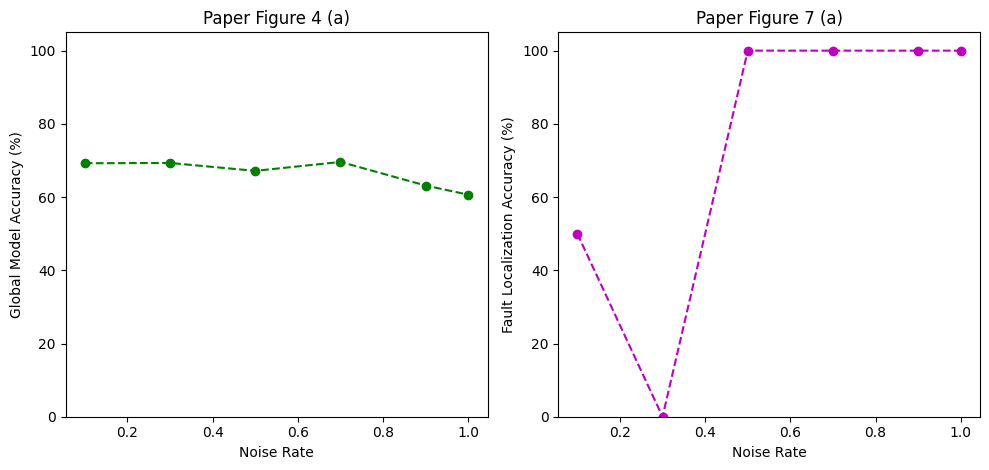

In [3]:
x =different_noise_levels 
y1_test_acc = [y[1] for y in nosie2results]
y2_fault_acc = [y[2] for y in nosie2results]
fig, axes = plt.subplots(1, 2) 
axes[0].plot(x, y1_test_acc, 'g--o') 
axes[1].plot(x, y2_fault_acc, 'm--o')

axes[0].set_xlabel('Noise Rate')
axes[1].set_xlabel('Noise Rate')
axes[0].set_ylabel('Global Model Accuracy (%)')
axes[1].set_ylabel('Fault Localization Accuracy (%)')
axes[0].set_title("Paper Figure 4 (a)")
axes[1].set_title("Paper Figure 7 (a)")

axes[0].set_ylim(0, 105)
axes[1].set_ylim(0, 105)

fig.set_figwidth(10)

plt.tight_layout()
